In [1]:
import numpy as np

import seaborn as sns
import pandas as pd
import polars as pl
import os
import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
import cvxpy as cp
import itertools
from scipy.special import logsumexp
from scipy.sparse import csr_matrix

sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/vivarium-ecoli'))

from ecoli.processes.metabolism_redux import NetworkFlowModel, FlowResult
from notebooks.fbagd.ck import CKNew, BiochemicalReactionNetwork, get_reaction_schematic

# Don't allow these concentrations to change during the simulation, regardless of their value.
FIXED_CONCENTRATIONS = ["PROTON[c]", "PROTON[p]", "WATER[c]", "WATER[p]"]

In [2]:
# jupyter autoreload modules

%load_ext autoreload

# Import simulation output

Before running this, run a sim in ecoli/experiments/metabolism_redux_sim.py with -n 2 to generate a simulation output. This is necessary to replicate the simulation environment. Use the default .json config.

In [3]:
time = '10'
date = '2024-04-27'
experiment = 'convex_kinetics'
entry = f'{experiment}_{time}_{date}'
folder = f'out/cofactors/{entry}/'

In [4]:
output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

In [5]:
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

In [6]:
stoichiometry = agent['ecoli-metabolism-redux-classic'].stoichiometry
process_rxn_names = agent['ecoli-metabolism-redux-classic'].reaction_names
process_met_names = agent['ecoli-metabolism-redux-classic'].metabolite_names
exchange_met_names = agent['ecoli-metabolism-redux-classic'].exchange_molecules
homeostatic_met_names = agent['ecoli-metabolism-redux-classic'].homeostatic_metabolites


# create dict of concentrations. they are in mM. 
cell_volume = mass['volume'][0] # fL
homeostatic_concentrations = agent['ecoli-metabolism-redux-classic'].homeostatic_concs
homeostatic_concentrations = {met: homeostatic_concentrations[i] for i, met in enumerate(homeostatic_met_names)}

# convert concentrations to counts
homeostatic_counts = {met: conc * 1e-3 * mass['volume'][0] * 1e-15 * 6.022e23  for met, conc in homeostatic_concentrations.items()}

# set OXALOACETIC_ACID[c] to 0
homeostatic_counts['OXALACETIC_ACID[c]'] = np.exp(9)

# get indices of 
# maintenance_reaction = agent['ecoli-metabolism-redux-classic'].model.maintenance_reaction
# stoichiometry["maintenance_reaction"] = maintenance_reaction

bad_rxns = ["RXN-12440", "TRANS-RXN-121", "TRANS-RXN-300", "TRANS-RXN-8", "R15-RXN-MET/CPD-479//CPD-479/MET.25.","DISULFOXRED-RXN[CCO-PERI-BAC]-MONOMER0-4152/MONOMER0-4438//MONOMER0-4438/MONOMER0-4152.71."]
# generate carbon mistake in parca, efflux/influx proton gen, iron cheating, mass gen
# for rxn in bad_rxns:
#    stoichiometry.pop(rxn, None)


Pandas automatically understands dicts of dicts as matrices.

# Test changing nutrient composition

In [7]:
raw_velocities = np.array(fba["estimated_fluxes"][4], dtype=np.float64)
catalyst_counts = np.array(fba["reaction_catalyst_counts"][4], dtype=np.float64)
# if catalyst count is <1 set to 1
catalyst_counts = np.array([1 if count < 1 else count for count in catalyst_counts])

# use reaction names to make a dict
d_velocities = {k: v for k, v in zip(process_rxn_names, raw_velocities)}

# only include nonzero fluxes in solution.velocities
nonzero_velocities = {k: v for k, v in d_velocities.items() if v != 0}
nonzero_velocities

{'1.5.1.20-RXN-5-METHYL-THF/NAD//METHYLENE-THF/NADH/PROTON.44. (reverse)': 4995.0,
 '1.8.4.8-RXN-3-5-ADP/SO3/Ox-thioredoxins-1/PROTON//PAPS/Red-thioredoxins-1.62. (reverse)': 7567.0,
 '1TRANSKETO-RXN': 8429.0,
 '2-DEHYDROPANTOATE-REDUCT-RXN (reverse)': 157.0,
 '2-ISOPROPYLMALATESYN-RXN': 25879.0,
 '2-OCTAPRENYL-6-METHOXYPHENOL-HYDROX-RXN': 7.0,
 '2-OCTAPRENYL-6-OHPHENOL-METHY-RXN': 7.0,
 '2-OCTAPRENYL-METHOXY-BENZOQ-METH-RXN': 7.0,
 '2-OCTAPRENYLPHENOL-HYDROX-RXN': 7.0,
 '2.3.1.157-RXN': 1178.0,
 '2.3.1.180-RXN': 10095.0,
 '2.5.1.19-RXN': 12995.0,
 '2.5.1.64-RXN': 15.0,
 '2.7.1.121-RXN': 196400.0,
 '2.7.1.148-RXN': 205.0,
 '2.7.3.9-RXN': 320335.0,
 '2.7.7.60-RXN': 205.0,
 '2.8.1.6-RXN': 1.0,
 '2OXOGLUTARATEDEH-RXN': 70474.0,
 '2PGADEHYDRAT-RXN': 543272.0,
 '2TRANSKETO-RXN (reverse)': 22533.0,
 '3-CH3-2-OXOBUTANOATE-OH-CH3-XFER-RXN-METHYLENE-THF/2-KETO-ISOVALERATE/WATER//2-DEHYDROPANTOATE/THF.62.': 157.0,
 '3-DEHYDROQUINATE-DEHYDRATASE-RXN': 12996.0,
 '3-DEHYDROQUINATE-SYNTHASE-RXN': 12

In [8]:
# sort nonzero velocities
sorted_velocities = {k: v for k, v in sorted(d_velocities.items(), key=lambda item: abs(item[1]), reverse=True)}
sorted_velocities

{'ATPSYN-RXN (reverse)': 2272963.0,
 'maintenance_reaction': 1775335.0,
 'TRANS-RXN-145': 1162240.0,
 'NADH-DEHYDROG-A-RXN-NADH/UBIQUINONE-8/PROTON//NAD/CPD-9956/PROTON.46.': 1056701.0,
 'TRANS-RXN0-545[CCO-PM-BAC-NEG]-CARBON-DIOXIDE//CARBON-DIOXIDE.47. (reverse)': 659704.0,
 'TRANS-RXN0-474': 615832.0,
 'RXN-21817-CPD-9956/PROTON/OXYGEN-MOLECULE//UBIQUINONE-8/PROTON/WATER.59.': 615799.0,
 'GAPOXNPHOSPHN-RXN': 614045.0,
 'PHOSGLYPHOS-RXN (reverse)': 614044.0,
 '3PGAREARR-RXN (reverse)': 543279.0,
 '2PGADEHYDRAT-RXN': 543272.0,
 'PYRUVDEH-RXN': 396328.0,
 'PGLUCISOM-RXN': 354342.0,
 'ARCBTRANS-RXN': 337734.0,
 'RXN0-7332': 337734.0,
 'RXN0-7336': 337734.0,
 '2.7.3.9-RXN': 320335.0,
 'TRANS-RXN-157-Hpr-pi-phospho-L-histidines/GLC//ALPHA-GLC-6-P/Hpr-Histidine.61.': 320008.0,
 'TRIOSEPISOMERIZATION-RXN (reverse)': 314949.0,
 'ASPARTASE-RXN (reverse)': 202269.0,
 'RXN0-313': 201600.0,
 'CITSYN-RXN': 201053.0,
 'RXN-14047': 200917.0,
 '2.7.1.121-RXN': 196400.0,
 'SUCCINATE-DEHYDROGENASE-UBIQ

# Filter S matrix to only include nonzero fluxes.

In [9]:
# reaction indices with nonzero fluxes
nonzero_rxn_indices = [process_rxn_names.index(k) for k in nonzero_velocities.keys()]

# get catalyst counts for nonzero fluxes
nonzero_f_catalyst_counts = np.array([catalyst_counts[i] for i in nonzero_rxn_indices])

# convert to array
nonzero_velocities = np.array(list(nonzero_velocities.values()))


In [10]:
# Use nonzero_velocities to filter S matrix
S_matrix_mask = stoichiometry[:, nonzero_rxn_indices] != 0

# remove rows of S_used that sum to zero.
nonzero_met_indices = np.where(S_matrix_mask.sum(axis=1) != 0)[0]
nonzero_met_names = [process_met_names[i] for i in nonzero_met_indices]
nonzero_rxn_names = [process_rxn_names[i] for i in nonzero_rxn_indices]
S_matrix = stoichiometry[:, nonzero_rxn_indices][nonzero_met_indices, :]

In [11]:
S_matrix.shape

(466, 438)

## Initialize optimization

In [12]:
# sort nonzero_velocities to be in same order as S_matrix columns.
vE_dict = nonzero_velocities
vE = np.array([np.array(list(vE_dict))], dtype=np.float64)
nE = np.array([np.array(list(nonzero_f_catalyst_counts))], dtype=np.float64)

dmdt = S_matrix @ vE.T

In [13]:
abs_dmdt = np.abs(dmdt)# np.max(np.array([dmdt, np.zeros(dmdt.shape)]), axis=0)
dmdt_mask = (abs_dmdt != 0).flatten()
lD = np.log(abs_dmdt[dmdt_mask]).flatten()

# Get exchange and homeostasis indices for compressed matrix

In [14]:
rxn_names = np.array(process_rxn_names)[nonzero_rxn_indices]
met_names = np.array(process_met_names)[nonzero_met_indices]

exchange_met_indices = np.array([i for i, met in enumerate(met_names) if met in exchange_met_names])
homeostatic_met_indices = np.array([i for i, met in enumerate(met_names) if met in homeostatic_met_names])
intermediate_met_indices = np.array([i for i, met in enumerate(met_names) if met not in exchange_met_names and met not in homeostatic_met_names])
fixed_c_indices = np.array([i for i, met in enumerate(met_names) if met in FIXED_CONCENTRATIONS])

# create array of expected concentrations
c_hom = np.zeros((len(met_names), 1))

# for each met, if in homeostatic, set to homeostatic concentration
for i, met in enumerate(met_names):
    if met in homeostatic_met_names:
        c_hom[i] = np.log(homeostatic_counts[met])
    else:
        c_hom[i] = -1


# First test. Single flux set. No eQuilibrator or regulation.

In [15]:
Sd = pd.DataFrame(S_matrix, columns=[k for k in nonzero_rxn_names])
# Sd = pd.DataFrame(stoich_dict, dtype=np.int8).fillna(0).astype(np.int8)
# Sd = Sd.iloc[0:7, 0:2]
Sr = None

Sd.shape

(466, 438)

In [16]:
E = CKNew()
y_f, y_r, y_s, y_p, y_i, y_a, cd_f, cfwd, crev, c, Km_s, Km_p, Km_i, Km_a, S_s, S_p, S_i, S_a, \
            met_s_nz, met_p_nz, met_i_nz, met_a_nz, rxn_s_nz, rxn_p_nz, rxn_i_nz, rxn_a_nz, \
            n_rxn, n_met, n_flux_set, S_s_nz, S_p_nz, S_s_mol, S_p_mol, S_b, S = E.set_up_variables(S_matrix=Sd, R_matrix=Sr, flow_data=vE, dmdt=dmdt)

Number of metabolites: 466, number of reactions: 438, number of flux sets: 1
Number of Km_s: 927, number of Km_p: 1039, number of Km_i: None, number of Km_a: None
Number of concentrations: (466, 1), number of y_f: (1, 927), number of y_r: (1, 1039)


In [17]:
C_alpha, C_beta, d_alpha, d_beta = E.construct_binding_matrix(n_rxn, S_s, S_p, S_i, S_a, Sr, met_s_nz, met_p_nz, met_i_nz, met_a_nz, rxn_s_nz, rxn_p_nz, rxn_i_nz, rxn_a_nz)

Shape of C_alpha: (1708, 927), shape of C_beta: (2294, 1039)
Shape of d_alpha: (1708,), shape of d_beta: (2294,)


In [18]:
LSE_expr, denom_expr = E.construct_kinetic_objective(vE, nE, n_flux_set, n_rxn, C_alpha, C_beta, d_alpha, 
                                                     d_beta, S_s_nz, S_p_nz, S_b, y_f, y_r, y_s, y_p, cfwd, crev)

In [19]:
loss = E.create_objective_function(cfwd, crev, c, Km_s, Km_p, Km_i, Km_a, y_s, y_p, denom_expr, dmdt, c_prior=10)

In [20]:
# remember, parameter bound is necessary for water Kms 
constr = E.set_parameter_bounds(cfwd, crev, c, Km_s, Km_p, Km_i, Km_a, LSE_expr, cd_f, lower_bound=-24, upper_bound=24)

In [21]:
# get met index of water
water_names = ['WATER[c]', 'WATER[p]']
water_indices = [i for i, met in enumerate(met_names) if met in water_names]

for idx in water_indices:
    constr = E.add_exact_concentration_constraints(constr, c, 18, idx)

# add objective to minimize deviation from concentrations where c_hom is not -1
loss += 0.01 * cp.sum(cp.abs((c - c_hom)[homeostatic_met_indices]))

In [22]:
problem = E.set_up_problem(loss, constr)


In [23]:
solution = E.solve(problem, solver=cp.CLARABEL)
solution.value

/Users/cyrus/.pyenv/versions/viv-10/lib/python3.10/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


2956.917095312248

## Check fit


(-1e-06, 1e-06)

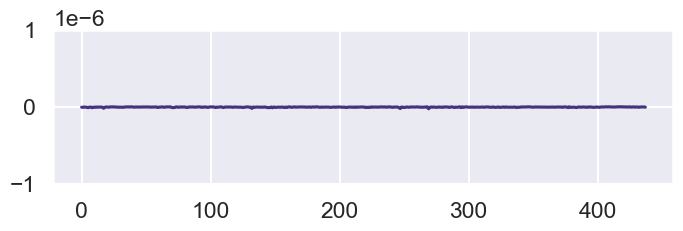

In [24]:
plt.figure(figsize=(8,2))

fit = E.evaluate_equality_fit(LSE_expr)

plt.plot(fit)

plt.ylim(-0.000001,0.000001)

In [25]:
reconstructed_vE = E.evaluate_flux_reconstruction(vE, nE, n_flux_set, n_rxn, S_b, S_s_nz, S_p_nz, d_alpha, d_beta, 
                                                  C_alpha, C_beta, y_f, y_r, y_s, y_p, cfwd, crev)

reconstructed_dmdt = S_matrix @ reconstructed_vE.T

recon_error = (reconstructed_vE - vE).flatten()
recon_rel_error = recon_error / vE.flatten()

recon_dmdt_error = (reconstructed_dmdt - dmdt).flatten()

rxn_index_range = np.arange(n_flux_set * n_rxn)
met_index_range = np.arange(n_flux_set * n_met)


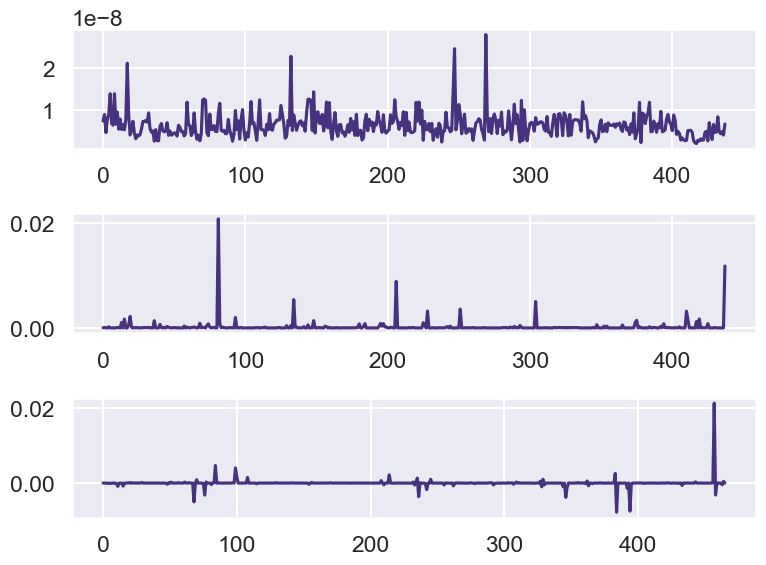

In [26]:

f, ax = plt.subplots(3, 1, figsize=(8,6))

ax[0].plot(rxn_index_range, recon_rel_error,)
ax[1].plot(rxn_index_range, recon_error,)
ax[2].plot(met_index_range, recon_dmdt_error,)

f.tight_layout()

# Check homeostatic concentration deviation

In [27]:
# check homeostatic conc deviation
c_dev = (c.value - c_hom)[homeostatic_met_indices].flatten()


np.array([c_dev, c.value.flatten()[homeostatic_met_indices], c_hom.flatten()[homeostatic_met_indices]]).T

array([[-3.67466058e-10,  1.13470871e+01,  1.13470871e+01],
       [-9.19332166e-10,  1.22863015e+01,  1.22863015e+01],
       [-3.48208573e-10,  1.09394457e+01,  1.09394457e+01],
       [-3.67478492e-10,  1.13470871e+01,  1.13470871e+01],
       [-4.16346069e-10,  1.21368611e+01,  1.21368611e+01],
       [-3.25046656e-10,  1.03749159e+01,  1.03749159e+01],
       [-2.81520585e-10,  9.50174338e+00,  9.50174338e+00],
       [-1.37164058e-09,  1.33839690e+01,  1.33839690e+01],
       [-5.69944092e-10,  1.33952473e+01,  1.33952473e+01],
       [-2.29372077e-10,  8.07328821e+00,  8.07328821e+00],
       [ 1.28552795e-01,  8.00000003e+00,  7.87144724e+00],
       [-4.74424056e-09,  1.26257371e+01,  1.26257371e+01],
       [-7.66606334e-10,  1.15894648e+01,  1.15894648e+01],
       [ 3.33134329e-01,  8.00000003e+00,  7.66686570e+00],
       [-2.41481501e-10,  8.31143821e+00,  8.31143821e+00],
       [-4.11988665e-10,  1.20781535e+01,  1.20781535e+01],
       [-5.12118348e-10,  1.24871009e+01

# Check parameter distributions

/var/folders/dx/0239zgvj0tgf46b5h8l7v_fc0000gn/T/ipykernel_33308/965055070.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  params = [[key, float(val)] for key, val_list in params.items() for val in val_list]


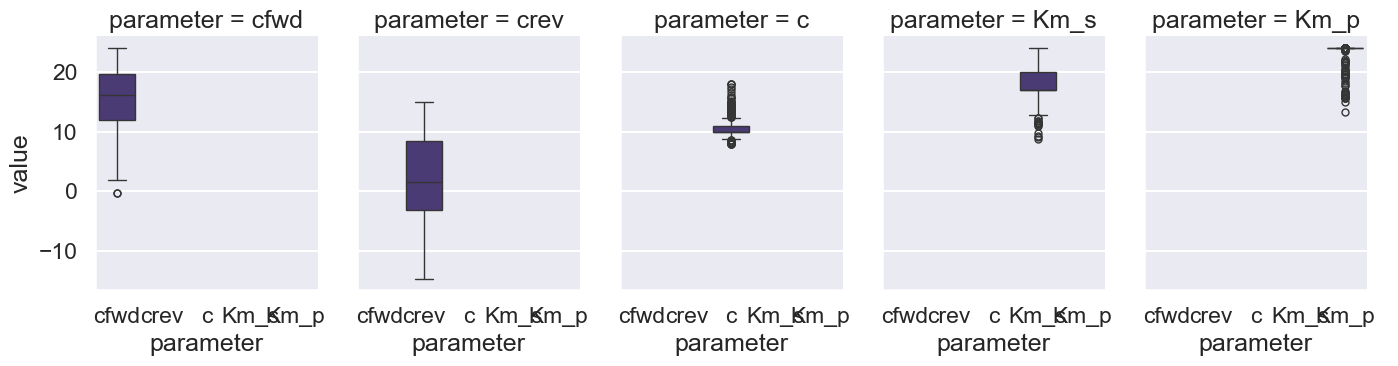

In [28]:
# create a dict of the parameter values
params = {"cfwd": cfwd.value, "crev": crev.value, "c": c.value, "Km_s": Km_s.value, "Km_p": Km_p.value}

# create single list of lists of the parameter values
# for each key, for each element in value list, create a list with the key and the value. that means many entries with same key. 
params = [[key, float(val)] for key, val_list in params.items() for val in val_list]

# create a dataframe from the list of lists
params_df = pd.DataFrame(params, columns=["parameter", "value"])

# plot boxplots of the parameter values

sns.catplot(data=params_df, x="parameter", y="value", col="parameter", kind="box", height=4, aspect=0.7)

# Simulation-structured recon

In [29]:
cn = np.array(c.value)[:, 0]

In [30]:
B = BiochemicalReactionNetwork()

v, dm = B.forward_step(cn, nonzero_f_catalyst_counts, S_matrix, cfwd, crev, Km_s, Km_p, Km_i, Km_a, S_s_nz, S_p_nz, S_s_mol, S_p_mol,
             S_b, C_alpha, C_beta, d_alpha, d_beta, n_rxn, met_s_nz, met_p_nz, met_i_nz, met_a_nz)

In [32]:
# simulate 100 timesteps
cur_cn = np.copy(cn)

n_step = 1000


dt = 0.001 # timestep

# only change internal concentrations, not external
internal_mask = np.ones_like(cn)
internal_mask[exchange_met_indices] = 0

# set up constant internal drain rate
dm_exit = np.zeros_like(cn)
dm_exit[homeostatic_met_indices] = -dmdt.flatten()[homeostatic_met_indices]

cn_over_time = np.zeros((n_step, len(cn)))
v_over_time = np.zeros((n_step, len(v)))
rel_dmdt_over_time = np.zeros((n_step, len(cn)))

for i in range(n_step):
    
    print(i)
    
    v, dm = B.forward_step(cur_cn, nonzero_f_catalyst_counts, S_matrix, cfwd, crev, Km_s, Km_p, Km_i, Km_a, S_s_nz, S_p_nz, S_s_mol, S_p_mol,
             S_b, C_alpha, C_beta, d_alpha, d_beta, n_rxn, met_s_nz, met_p_nz, met_i_nz, met_a_nz, noise=0.1)
    
    
    # if adjusting demand based on concentration, need to adjust dm_exit
    concentration_factor = np.exp(cur_cn - cn)
    
    # noise in demand
    dm_exit_var = dm_exit * np.random.normal(1, 0.1, size=dm_exit.shape) * concentration_factor
    
    # dm_tot = (dm + dm_exit) * dt
    dm_tot = (dm + dm_exit_var) * dt
    

    # set external dmdt to zero
    dm_tot[exchange_met_indices] = 0
    dm_tot[fixed_c_indices] = 0
    
    
    debug = np.exp(cur_cn) + dm_tot
    if np.any(debug < 0):
        print('negative concentration')
        # find metabolites with negative concentration
        neg_indices = np.where(debug < 0)[0]
        print(met_names[neg_indices])
        print(np.exp(cur_cn)[neg_indices])
        print(dm[neg_indices] * dt)
        print(neg_indices)
        
        break
    
    # update internal concentrations
    cur_cn = np.log(np.exp(cur_cn) + dm_tot)
    rel_dmdt_over_time[i, :] = dm_tot / np.exp(cur_cn)
    
    cn_over_time[i, :] = cur_cn
    v_over_time[i, :] = v
    
     

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

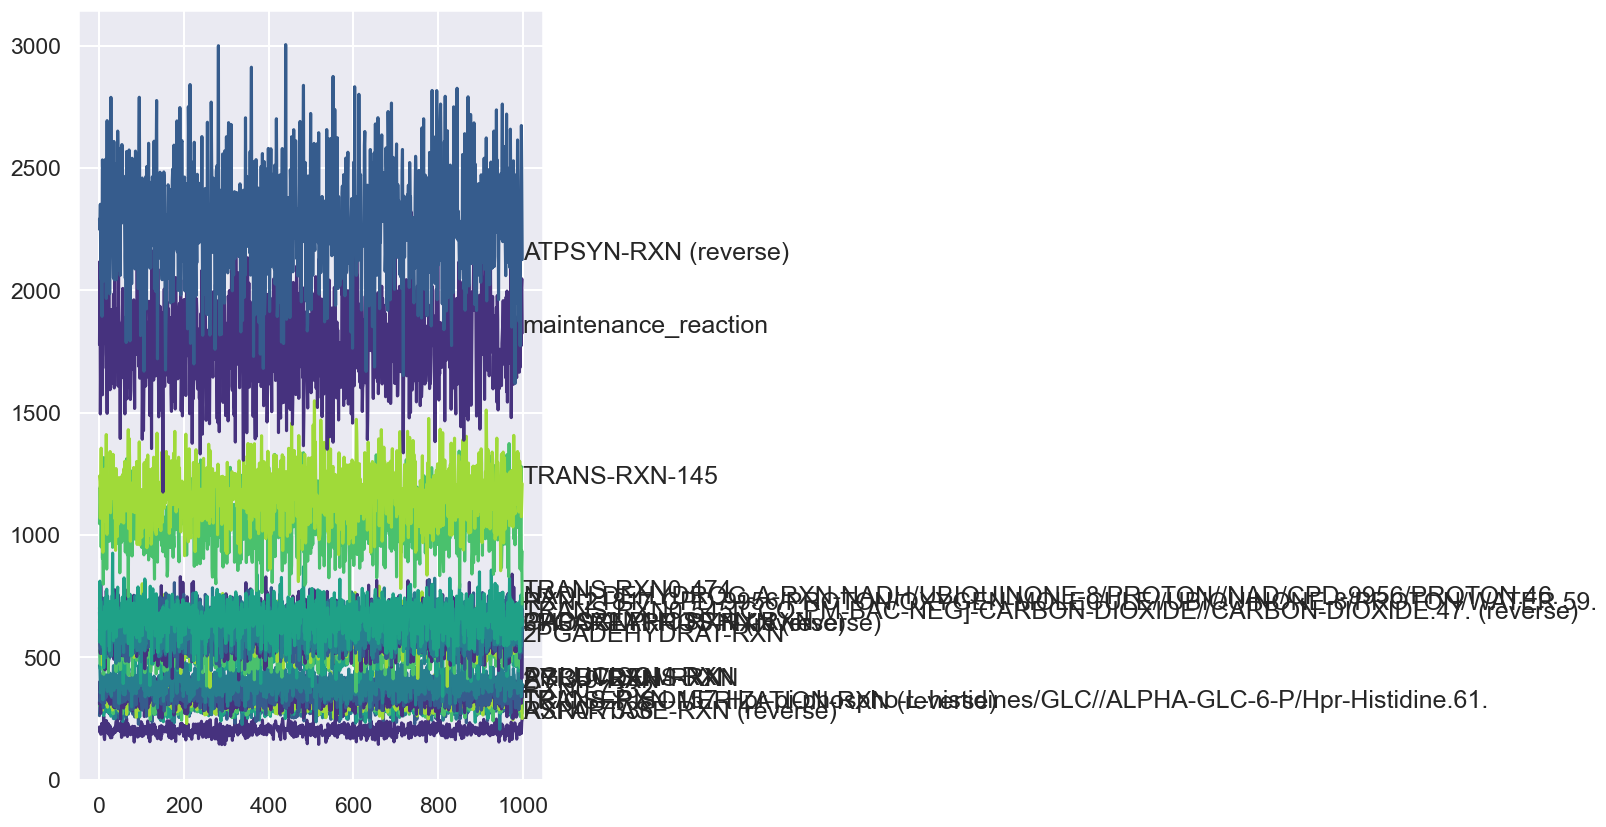

In [33]:
# plt.plot(dt * v_over_time)
plt.figure(figsize=(6,10))

# plot the curves with the 10 highest averages
v_sorted = np.mean(v_over_time, axis=0)
v_sorted = np.argsort(v_sorted)

plt.plot(dt * v_over_time[:, v_sorted[-20:]])

# log scale

# for each curve, write the name of the reaction next to it
for i in range(20):
    plt.text(n_step, dt * v_over_time[-1, v_sorted[-20 + i]], rxn_names[v_sorted[-20 + i]])

# flip x and y

(0.0, 15000.0)

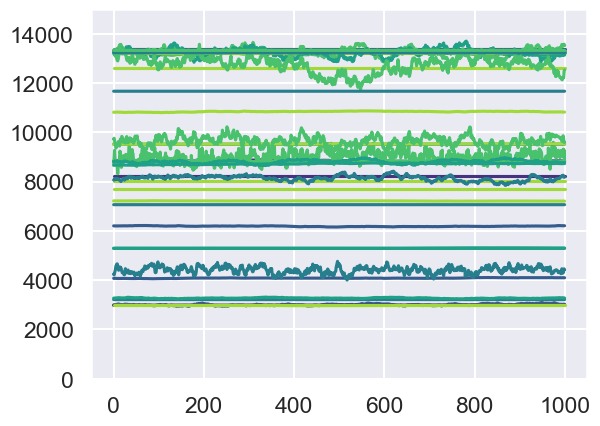

In [34]:
plt.plot(np.exp(cn_over_time[0:1000,:]))

plt.ylim(5.8,6.2)
plt.ylim(0, 15000)

(0.0, 15000.0)

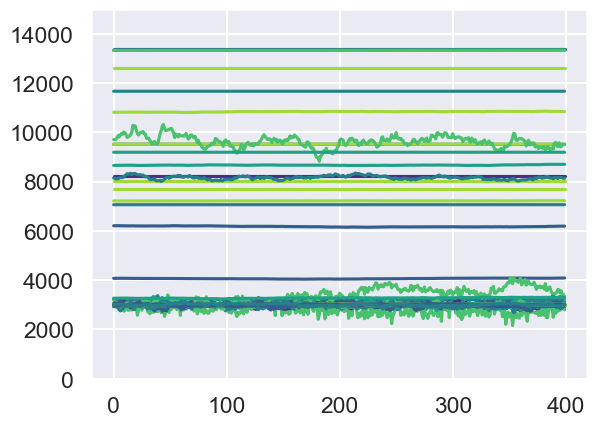

In [35]:
plt.plot(np.exp(cn_over_time[0:400,:]))

plt.ylim(5.8,6.2)
plt.ylim(0, 15000)

# plt.plot(dt * v_over_time)
    

# Try to simulate concentration changes over time

In [37]:
# don't change external exchange concentrations
# for internal exchange concentrations, take out a small amount per timestep



## Old. Get equilibrium constant estimates

In [13]:
from equilibrator_api import ComponentContribution, Q_, Reaction

cc = ComponentContribution()

In [14]:
# separate met names into name and compartment
met_names_split = [met.split('[') for met in nonzero_met_names]

# remove second bracket from compartment
met_names_split = [[met[0], met[1][:-1]] for met in met_names_split]

# for each met, try to get the compound
for met in met_names_split:
    compound = cc.get_compound(f"metacyc.compound:{met[0]}")
    
    if compound is not None and compound.inchi_key is None:
        met.append(None)
    
    else:
        met.append(compound)

# Create dataframe
met_df = pl.DataFrame(met_names_split, schema=["name", "compartment", "compound"])

# create reaction dict
thermo_rxn_dict = {}

# for each reaction, get the reactants and products
for i, rxn in enumerate(nonzero_rxn_names):
    met_indices = np.where(S_matrix[:, i] != 0)[0]
    
    rxn_dict = {}
    rxn_flag = True
    compartments = set()
    
    for met_idx in met_indices:
        cur_row = met_df.row(met_idx)
        
        met_name = cur_row[0]
        compartment = cur_row[1]
        compound = cur_row[2]
        
        rxn_dict[compound] = S_matrix[met_idx, i]
        
        compartments.add(compartment)
        
        if compound is None:
            rxn_flag = False
        
        # handle multiple compartments separately
        if len(compartments) > 1:
            rxn_flag = False
    
    if rxn_flag:
        thermo_rxn_dict[rxn] = Reaction(rxn_dict)

In [15]:
met_df

name,compartment,compound
str,str,object
"""1-AMINO-PROPAN-2-ONE-3-PHOSPHA…","""c""","Compound(id=1120, inchi_key=HIQNVODXENYOFK-UHFFFAOYSA-M)"
"""1-PALMITOYLGLYCEROL-3-PHOSPHAT…","""c""","Compound(id=691181, inchi_key=YNDYKPRNFWPPFU-UHFFFAOYSA-L)"
"""10-FORMYL-THF""","""c""","Compound(id=224, inchi_key=AUFGTPPARQZWDO-YPMHNXCESA-L)"
"""2-3-DIHYDROXYBENZOATE""","""c""","Compound(id=434, inchi_key=GLDQAMYCGOIJDV-UHFFFAOYSA-M)"
"""2-ACETO-LACTATE""","""c""","Compound(id=88365, inchi_key=NMDWGEGFJUBKLB-YFKPBYRVSA-M)"
…,…,…
"""ZN+2""","""c""","Compound(id=141, inchi_key=PTFCDOFLOPIGGS-UHFFFAOYSA-N)"
"""ZN+2""","""p""","Compound(id=141, inchi_key=PTFCDOFLOPIGGS-UHFFFAOYSA-N)"
"""biotin-L-lysine-in-BCCP-dimers""","""c""",null


In [16]:
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.0)
cc.ionic_strength = Q_("0.25M")
cc.temperature = Q_("298.15K")

R = 0.008314 # kJ/mol*K
T = 298.15 # K 



# (standard_dg_prime, dg_uncertainty) = cc.standard_dg_prime_multi(list(thermo_rxn_dict.values()), uncertainty_representation="cov")

# for each rxn in thermo_rxn_dict, get the standard_dg_prime
standard_dg_prime = pl.DataFrame([[name, cc.standard_dg_prime(rxn).magnitude.nominal_value, 
                               cc.standard_dg_prime(rxn).magnitude.std_dev] for name, rxn in thermo_rxn_dict.items()])

In [17]:
standard_dg_prime

column_0,column_1,column_2
str,f64,f64
"""1.5.1.20-RXN-5-METHYL-THF/NAD/…",-1.8689,4.626933
"""1TRANSKETO-RXN""",3.838866,1.921333
"""2-DEHYDROPANTOATE-REDUCT-RXN (…",-16.5399,2.931871
"""2-ISOPROPYLMALATESYN-RXN""",-25.915348,1.347144
"""2-OCTAPRENYL-6-METHOXYPHENOL-H…",-440.281234,3.759025
…,…,…
"""UGD-RXN""",-26.705204,2.201167
"""URA-PHOSPH-RXN (reverse)""",-4.499144,2.003788
"""UROGENDECARBOX-RXN""",-24.713125,12.416143


In [18]:
thermo_rxn_dict['AMPSYN-RXN']

In [19]:
dg = cc.standard_dg_prime(thermo_rxn_dict['AMPSYN-RXN'])

type(dg.magnitude.nominal_value)

float

In [20]:
dir(dg.magnitude)

['__abs__',
 '__add__',
 '__bool__',
 '__class__',
 '__complex__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__le__',
 '__long__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__trunc__',
 '_linear_part',
 '_nominal_value',
 'derivatives',
 'dtype',
 'error_components',
 'format',
 'n',
 'nominal_value',
 's',
 'std_dev',
 'std_score']

In [21]:
dg.magnitude.std_dev

4.298452923905563

In [22]:
get_reaction_schematic(S_matrix,  nonzero_rxn_names, nonzero_met_names, 'AMPSYN-RXN')

{'ADENYLOSUCC[c]': -1, 'AMP[c]': 1, 'FUM[c]': 1}

In [23]:
standard_dg_prime._magnitude

# argsort and show sorted rxn names
sorted_rxn_indices = np.argsort(standard_dg_prime._magnitude)
sorted_rxn_names = [nonzero_rxn_names[i] for i in sorted_rxn_indices]
sorted_rxn_names

AttributeError: 'DataFrame' object has no attribute '_magnitude'